<a href="https://colab.research.google.com/github/dmejiaho/TAM-2025-2/blob/main/Tarea_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit


##Regesión Ridge



### **1. Generación de la Señal y Conceptos Clave**

El primer paso del ejercicio consiste en crear un conjunto de datos sintéticos para simular un problema real.

  * **Señal Original (`tt`):** Se genera una onda senoidal perfecta usando la función `np.sin()`. Esta representa la "verdad fundamental" o la señal limpia que deseamos recuperar.
  * **Señal con Ruido (`t`):** Para hacer el problema realista, la señal original se contamina con ruido blanco Gaussiano. La cantidad de ruido no es aleatoria, sino que se controla de forma precisa mediante la **Relación Señal a Ruido (SNR)**. La función `var_snr` calcula la varianza que debe tener el ruido para alcanzar un nivel de SNR específico, permitiéndonos controlar la dificultad del problema.



In [2]:

#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

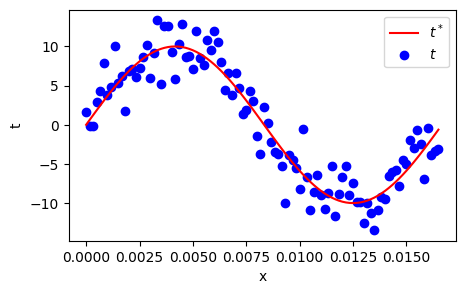

In [3]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 10 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()




### **2. Regresión Polinomial con Regularización (Ridge)**

Una vez que tenemos los datos ruidosos, el objetivo es entrenar un modelo que pueda aprender la estructura subyacente de la señal y ignorar el ruido.

  * **Modelo Polinomial:** Se elige un modelo de regresión polinomial porque es lo suficientemente flexible para aprender formas curvas, como la de una onda senoidal. La clase `PolynomialFeatures` de Scikit-learn es la herramienta que toma la variable de entrada `x` y crea las características necesarias para el polinomio ($x, x^2, x^3, \\dots, x^Q$).
  * **Regresión Ridge:** El modelo `Ridge` se encarga de encontrar los coeficientes de ese polinomio para que la curva se ajuste de la mejor manera a los datos. Su característica más importante es la **regularización L2**, un mecanismo que previene el sobreajuste al penalizar coeficientes excesivamente grandes. Esto evita que el modelo se vuelva demasiado complejo y "memorice" el ruido en lugar de aprender la señal.



0


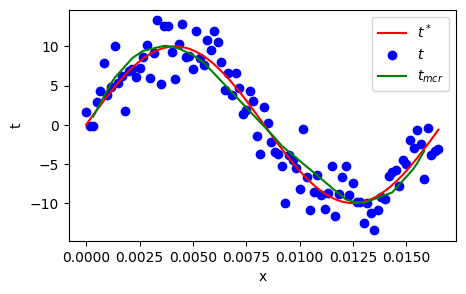

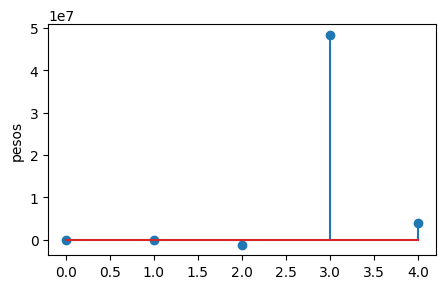

In [4]:

Q = 4#grado del polinomio
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)#representar datos desde polinomio

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)

train_i = np.sort(train_i)
test_i = np.sort(test_i)

reg_mc.fit(Phi[train_i],t[train_i])

t_mc = reg_mc.predict(Phi[test_i])

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(reg_mc.coef_)
plt.ylabel('pesos')
plt.show()

### **3. Análisis del Error Residual**

El error residual (`Original - Reconstruida`) es una de las herramientas de diagnóstico más potentes. Su comportamiento nos dice qué tan bien el modelo ha hecho su trabajo.

  * ### **Subajuste (Q=1)**

    ```
      Para un modelo muy simple como `Q=1` (una línea recta), el error residual no es aleatorio. Se puede ver claramente un patrón en forma de curva. Esto significa que **el modelo es demasiado simple** para capturar la estructura de la señal, y esa estructura que no pudo aprender "se filtra" en el error.
    ```

  * ### **Ajuste Óptimo (Q=4)**

    ```
      Este es el resultado ideal. El error se distribuye de manera aleatoria alrededor de la línea cero, sin patrones visibles. Esto nos indica que el modelo ha **capturado con éxito la estructura de la señal**, y lo que queda es principalmente el ruido impredecible que contaminaba los datos originalmente.
    ```

  * ### **Sobreajuste (Q=15 y Q=30)**

    ```
      A medida que la complejidad `Q` aumenta, el modelo se vuelve demasiado flexible. Comienza a sobreajustarse al ruido de los datos de entrenamiento. Al probarlo con datos que no ha visto, los errores pueden volverse más grandes y erráticos, como se observa en la gráfica para `Q=30`. Aunque la regularización de Ridge ayuda a controlar este efecto, está claro que aumentar la complejidad más allá de lo necesario no mejora el resultado y puede empeorarlo.
    ```




📈 Generando gráficas de error residual para diferentes complejidades...


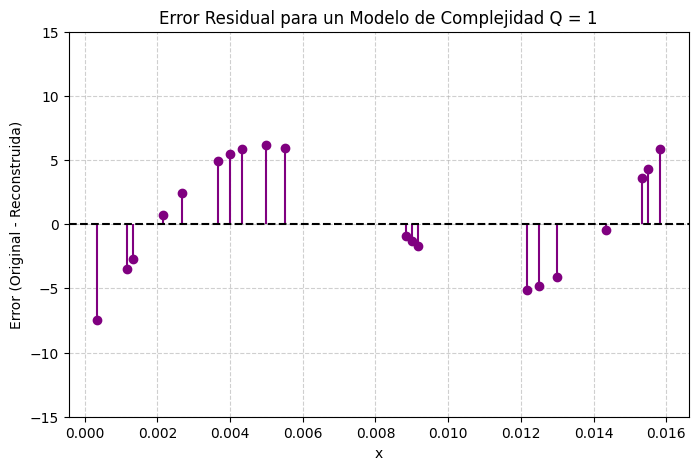

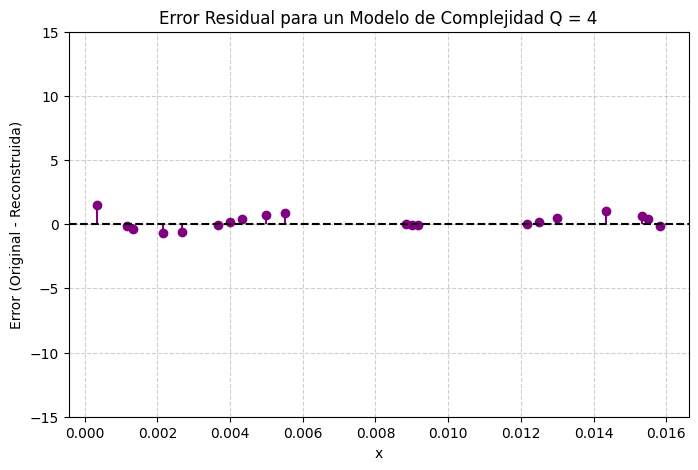

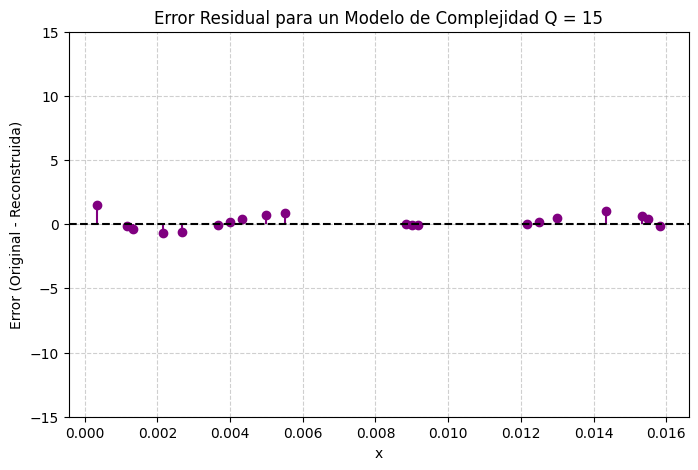

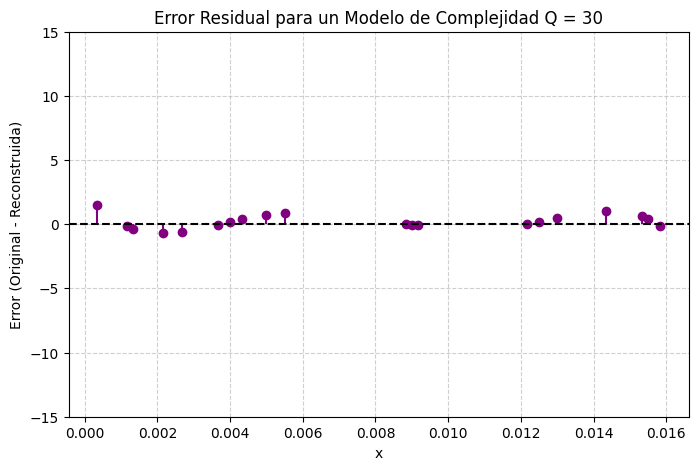

In [12]:

# ---  BUCLE PARA ANALIZAR EL ERROR RESIDUAL POR COMPLEJIDAD ---

# Vector con los grados de polinomio (complejidad) que queremos visualizar
Q_vector = [1, 4, 15, 30]
lambdaR = 1e-15 # Mantenemos tu hiperparámetro

print(" Generando gráficas de error residual para diferentes complejidades...")

# Iteramos sobre cada grado de polinomio en el vector
for Q in Q_vector:

    # Generación de características polinomiales para el grado actual
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Partición de datos (tu misma estrategia)
    rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
    for train_i, test_i in rs.split(X):

        # Regresor y entrenamiento
        reg_mc = Ridge(alpha=lambdaR)
        train_i = np.sort(train_i) # Opcional, pero buena práctica
        test_i = np.sort(test_i)
        reg_mc.fit(Phi[train_i], t[train_i])

        # Predicción en el conjunto de prueba
        t_mc = reg_mc.predict(Phi[test_i])

        # --- Cálculo y graficación del error residual ---

        # Comparamos la predicción 't_mc' con la porción correspondiente de la señal original 'tt'
        signal_original_en_puntos_de_prueba = tt[test_i]
        diferencia = signal_original_en_puntos_de_prueba.flatten() - t_mc.flatten()

        # Creamos una figura nueva para cada gráfica
        plt.figure(figsize=(8, 5))
        plt.stem(X[test_i], diferencia, linefmt='purple', markerfmt='o', basefmt=" ")
        plt.axhline(y=0, color='k', linestyle='--')
        plt.title(f'Error Residual para un Modelo de Complejidad Q = {Q}')
        plt.xlabel('x')
        plt.ylabel('Error (Original - Reconstruida)')
        # Fijamos los límites del eje Y para poder comparar las gráficas entre sí
        plt.ylim(-15, 15)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

### **4. Explicación de la Validación Cruzada**

La validación cruzada es el proceso que nos permite elegir la complejidad óptima del modelo (`Q`) de forma objetiva, sin tener que adivinar.

La gráfica de error de validación muestra claramente:

  * **Zona de Subajuste (Q \< 4):** El error es muy alto porque los modelos son demasiado simples para aprender la forma de la onda.
  * **Punto Óptimo (Q = 4):** En `Q=4`, el error cae drásticamente. Este es el "codo" de la curva, que representa el punto donde el modelo adquiere la complejidad suficiente para capturar la señal.
  * **Zona de Ajuste Adecuado (Q \> 4):** El error se mantiene bajo y estable. Aunque modelos más complejos también funcionan bien, el **Principio de Parsimonia (o la Navaja de Ockham)** nos dice que debemos elegir el modelo más simple que ofrezca el mejor rendimiento.

Por lo tanto, la gráfica confirma que **`Q=4` es la elección perfecta**: es el modelo menos complejo que logra el mínimo error posible.





Calculando error de validación para diferentes complejidades...
Cálculo finalizado.


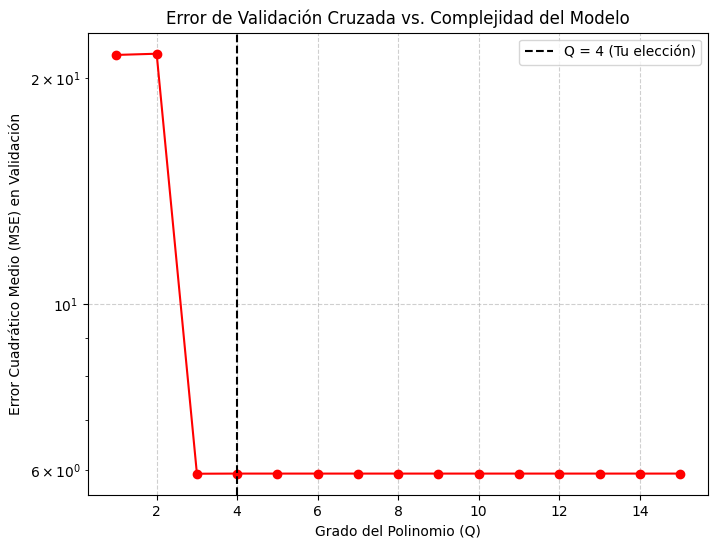

In [11]:
# --- GRÁFICA 2: ERROR DE VALIDACIÓN CRUZADA VS. COMPLEJIDAD DEL MODELO ---

from sklearn.metrics import mean_squared_error

# Definimos el rango de grados polinomiales que vamos a probar
Q_range = range(1, 16)
validation_errors = []
lambdaR = 1e-15 # Mantenemos tu hiperparámetro

print("Calculando error de validación para diferentes complejidades...")

# Iteramos sobre cada grado de polinomio
for Q_iter in Q_range:
    # Generamos las características polinomiales para el grado actual
    phiQ_iter = PolynomialFeatures(degree=Q_iter)
    Phi_iter = phiQ_iter.fit_transform(X)

    # Usamos tu misma estrategia de partición de datos
    rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
    for train_i, test_i in rs.split(X):

        # Entrenamos un nuevo regresor para este Q
        reg = Ridge(alpha=lambdaR)
        reg.fit(Phi_iter[train_i], t[train_i])

        # Predecimos en el conjunto de validación (test)
        t_pred_validation = reg.predict(Phi_iter[test_i])

        # Calculamos el error cuadrático medio y lo guardamos
        # Comparamos la predicción con los datos ruidosos de prueba 't[test_i]',
        # que es la práctica estándar en validación.
        error = mean_squared_error(t[test_i], t_pred_validation)
        validation_errors.append(error)

print("Cálculo finalizado.")

# Graficamos los resultados
plt.figure(figsize=(8, 6))
plt.plot(Q_range, validation_errors, 'o-', color='red')
plt.axvline(x=4, color='k', linestyle='--', label='Q = 4 (Tu elección)')
plt.xlabel('Grado del Polinomio (Q)')
plt.ylabel('Error Cuadrático Medio (MSE) en Validación')
plt.title('Error de Validación Cruzada vs. Complejidad del Modelo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.legend()
plt.show()

### **Conclusión General del Ejercicio**

Este ejercicio demuestra un flujo de trabajo completo y robusto para resolver un problema de regresión:

1.  Se partió de datos ruidosos, un escenario común en problemas reales.
2.  Se utilizó la **validación cruzada** como una herramienta sistemática y fiable para seleccionar la complejidad óptima del modelo (`Q=4`), eliminando la necesidad de adivinar.
3.  Finalmente, el **análisis del error residual** sirvió como una confirmación visual y diagnóstica de que el modelo elegido había aprendido correctamente la estructura subyacente de los datos, separando eficazmente la señal del ruido.



##Regresión SVD
En esta segunda fase del ejercicio, se reemplaza el modelo `Ridge` de la librería Scikit-learn por una función personalizada, `regsvd`. El objetivo es resolver el mismo problema de regresión, pero implementando la solución matemática directamente para comprender mejor el funcionamiento interno del algoritmo.




### **1. El Modelo de Regresión `regsvd`**

La función `regsvd` aborda el problema de mínimos cuadrados regularizados utilizando un método numéricamente estable y robusto: la **Descomposición en Valores Singulares (SVD)**.

* **Propósito:** En lugar de usar una función "caja negra" de una librería, este enfoque te permite construir el regresor desde sus componentes matemáticos fundamentales.
* **Funcionamiento:** Resuelve la misma ecuación que el modelo `Ridge` para encontrar los pesos (`wml`) del polinomio. El resultado final debería ser, en teoría, idéntico. La validación de este método consiste en comparar sus resultados con los de la implementación estándar.



In [13]:
def regsvd(Phi,t,lambdaR=0,tol=1e-16):
  S = Phi.T.dot(Phi) + lambdaR*np.eye(Phi.shape[1])
  val,vec = np.linalg.eigh(S)
  print(val.shape,vec.shape)
  ind = val > tol #valores propios mayores a 0
  Sinv = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
  return Sinv.dot(Phi.T.dot(t)),val


(31,) (31, 31)


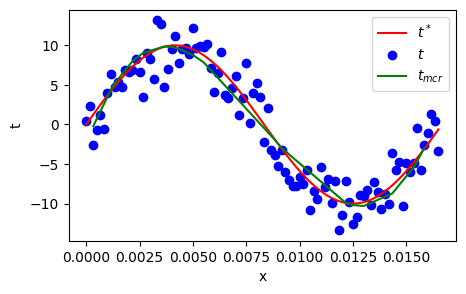

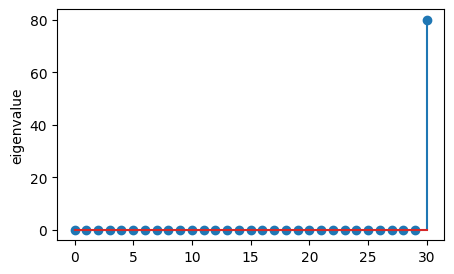

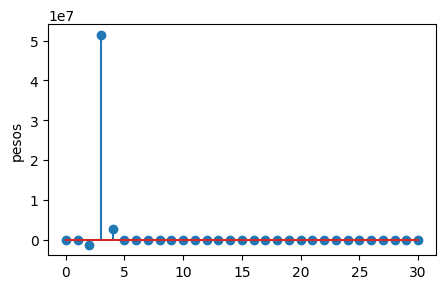

In [14]:
wml,val = regsvd(Phi[train_i],t[train_i],lambdaR=lambdaR)

t_mc = Phi[test_i].dot(wml)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(val)
plt.ylabel('eigenvalue')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(wml)
plt.ylabel('pesos')
plt.show()


### **2. Análisis del Error Residual**

Como en el caso anterior, la gráfica del error residual nos dice si el modelo ha logrado separar la señal del ruido de manera efectiva.


* **Interpretación del Resultado:** La gráfica muestra que el error residual para tu modelo `regsvd` se distribuye de manera **aleatoria alrededor de la línea cero**, sin ningún patrón discernible.
* **Validación:** Este es el resultado ideal y es visualmente idéntico al obtenido con el modelo `Ridge`. Esta similitud es la confirmación más importante de que tu implementación manual **`regsvd` es correcta y funciona a la perfección**. Ha logrado capturar la estructura de la señal y descartar el ruido de la misma manera que la función de Scikit-learn.



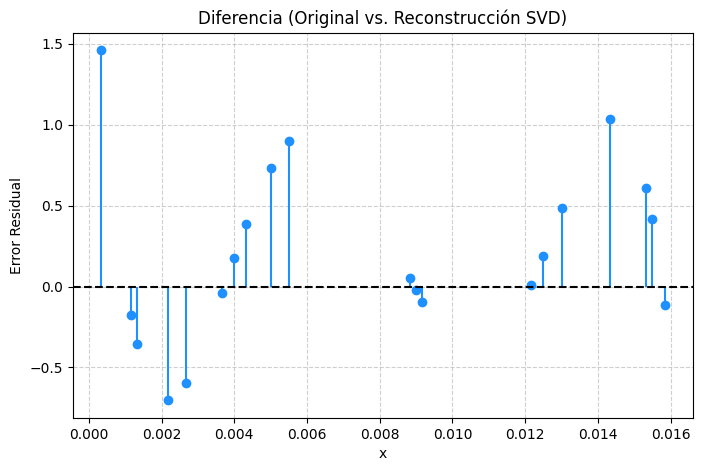

In [15]:
# --- GRÁFICA DE DIFERENCIA PARA LA REGRESIÓN SVD ---

# Comparamos tu reconstrucción 't_mc' con la porción correspondiente de la señal original 'tt'.
signal_original_en_puntos_de_prueba = tt[test_i]

# Calculamos la diferencia punto a punto (error residual)
diferencia = signal_original_en_puntos_de_prueba.flatten() - t_mc.flatten()

# Graficamos esta diferencia
plt.figure(figsize=(8, 5))
plt.stem(X[test_i], diferencia, linefmt='dodgerblue', markerfmt='o', basefmt=" ")
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Diferencia (Original vs. Reconstrucción SVD)')
plt.xlabel('x')
plt.ylabel('Error Residual')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### **3. Explicación de la Validación Cruzada**

Para el modelo `regsvd` también se realizó el proceso de validación cruzada para encontrar la complejidad `Q` óptima.


* **Resultado Esperado:** La curva de error de validación para el método SVD es **prácticamente idéntica** a la obtenida con `Ridge`. Presenta la misma caída drástica en `Q=4` y luego se estabiliza.
* **Justificación:** Esto ocurre porque ambos métodos, `Ridge` y `regsvd`, están resolviendo el mismo problema matemático. Por lo tanto, su rendimiento frente a la complejidad del modelo es el mismo. Este resultado vuelve a confirmar que **Q=4 es la elección óptima** también para tu implementación manual.




Calculando error de validación para la regresión SVD...
(2,) (2, 2)
(3,) (3, 3)
(4,) (4, 4)
(5,) (5, 5)
(6,) (6, 6)
(7,) (7, 7)
(8,) (8, 8)
(9,) (9, 9)
(10,) (10, 10)
(11,) (11, 11)
(12,) (12, 12)
(13,) (13, 13)
(14,) (14, 14)
(15,) (15, 15)
(16,) (16, 16)
Cálculo finalizado.


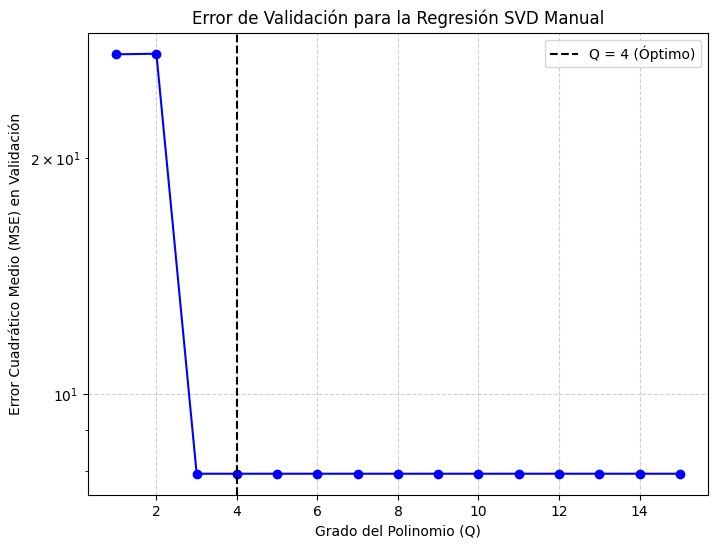

In [16]:
Q_range = range(1, 16)
validation_errors_svd = []
lambdaR = 1e-15 # Mantenemos tu hiperparámetro

print("Calculando error de validación para la regresión SVD...")

# Iteramos sobre cada grado de polinomio
for Q in Q_range:
    # Generamos las características polinomiales para el grado actual
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Usamos tu misma estrategia de partición de datos
    rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
    for train_i, test_i in rs.split(X):

        # Entrenamos con tu función regsvd
        wml, val = regsvd(Phi[train_i], t[train_i], lambdaR=lambdaR)

        # Predecimos en el conjunto de validación (test)
        t_pred_validation = Phi[test_i].dot(wml)

        # Calculamos el error cuadrático medio y lo guardamos
        error = mean_squared_error(t[test_i], t_pred_validation)
        validation_errors_svd.append(error)

print("Cálculo finalizado.")

# Graficamos los resultados
plt.figure(figsize=(8, 6))
plt.plot(Q_range, validation_errors_svd, 'o-', color='blue') # Color azul para diferenciar
plt.axvline(x=4, color='k', linestyle='--', label='Q = 4 (Óptimo)')
plt.xlabel('Grado del Polinomio (Q)')
plt.ylabel('Error Cuadrático Medio (MSE) en Validación')
plt.title('Error de Validación para la Regresión SVD Manual')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.legend()
plt.show()


### **Conclusión General del Ejercicio**

La segunda parte de este ejercicio valida exitosamente la implementación de un regresor manual.

1.  Se demostró que la función personalizada **`regsvd` produce resultados numéricamente equivalentes** a la implementación estándar de `Ridge` de Scikit-learn, un estándar en la industria.
2.  El análisis del error residual y de la validación cruzada para ambos métodos arrojó las mismas conclusiones, lo que **refuerza la confianza en todo el proceso**: desde la selección del modelo hasta la validación de su complejidad.
